# Categorização de produtos usando Bag of Words
## classificador: Decision-Tree

Bibliotecas e Configurações

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 
import boto3


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

Importando o Dataset

In [2]:
path = 's3://data/'
file_train = 'sample_products.csv'
file_test =  'test_products.csv'
endpoint_url='http://minio:9000'
AWS_ACCESS_KEY_ID = 'minio'
AWS_SECRET_ACCESS_KEY = 'minio123'
storage_options={
        "key": AWS_ACCESS_KEY_ID,
        "secret": AWS_SECRET_ACCESS_KEY,
        "client_kwargs": {"endpoint_url": endpoint_url}
    }

df_train = pd.read_csv(path+file_train,storage_options=storage_options)
df_test = pd.read_csv(path+file_test,storage_options=storage_options)

Verificando colunas do Dataset

In [3]:
df_train.columns

Index(['product_id', 'seller_id', 'query', 'search_page', 'position', 'title',
       'concatenated_tags', 'creation_date', 'price', 'weight',
       'express_delivery', 'minimum_quantity', 'view_counts', 'order_counts',
       'category'],
      dtype='object')

Analisando os dados

In [4]:
print("Número de Linhas por categoria:")
print(df_train['category'].value_counts())

Número de Linhas por categoria:
Lembrancinhas         17524
Decoração              8723
Bebê                   6930
Papel e Cia            2750
Outros                 1133
Bijuterias e Jóias      940
Name: category, dtype: int64


Plotando o número de produtos por categoria

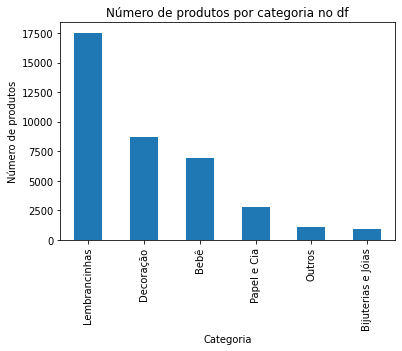

In [5]:
plt.figure()
pd.value_counts(df_train['category']).plot.bar(title="Número de produtos por categoria no df")
plt.xlabel("Categoria")
plt.ylabel("Número de produtos")
plt.show()

Podemos perceber que o número de produtos por categoria não é similar.

Uma possivel abordagem é o uso de algoritmos baseados em árvore de dedicão, onde  mesmo com o desbalanceamento de classe a árvore de decisão consegue crescer para as categorias com mais dados, sem impactar a performance de categorias com menos dados de treinamento.

### Pré-processamento

Removendo produtos duplicados

In [6]:
df_copy = df_train.copy()
df_copy = df_copy.drop_duplicates('product_id')

Concatenando título, query e tags

In [7]:
df_copy["text"] = df_copy["concatenated_tags"] + " " + df_copy["query"]+ " " + df_copy["title"]
df_copy = df_copy[df_copy["text"].notnull()]

Criar uma coluna para cada categoria

In [8]:
df_copy = df_copy.fillna(0)
df_one = pd.get_dummies(df_copy.category)
print(df_one.head())
df_copy = pd.concat([df_copy, df_one], axis=1)

   Bebê  Bijuterias e Jóias  Decoração  Lembrancinhas  Outros  Papel e Cia
0     0                   0          1              0       0            0
1     0                   0          0              0       0            1
2     0                   0          0              0       1            0
3     1                   0          0              0       0            0
4     0                   0          1              0       0            0


### Extração das Features e Construção do Dicionário

Tokeniza o texto

In [9]:
vectorizer = CountVectorizer()
tokenizer = vectorizer.build_tokenizer()
df_copy['tokenized_text'] = df_copy['text'].apply(lambda x: tokenizer(x))

Separando conjunto de treinamento e test

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(df_copy,df_copy['category'].to_list(),test_size=0.3, shuffle=True,random_state=15)

Construi o dicionário que mapeia cada palavra a um inteiro

In [11]:
my_words = []
X_train['tokenized_text'].apply(lambda x: [my_words.append(word) for word in x])
train_counts = vectorizer.fit(my_words)
print("Total unique words:")
print(len(train_counts.vocabulary_))
print("\nSample data from dictionary:")
i = 0
# Print top 4 (word, id) tuples
for key in vectorizer.vocabulary_:
    print("Word: {} - ID: {} ".format(key, vectorizer.vocabulary_[key]))
    if i == 3:
        break
    i += 1

Total unique words:
10633

Sample data from dictionary:
Word: canetas - ID: 2486 
Word: personalizadas - ID: 7951 
Word: caneta - ID: 2485 
Word: brinde - ID: 2239 


Extrai as features para o conjunto de treinamento

In [12]:
#df_copy['tokenized_text'] = df_copy[df_copy['tokenized_text'].size > 0]
for line in X_train['tokenized_text']:
    print("Line:")
    print(line)
    print("tamanho")
    print(len(line))
    print("matriz")
    m = vectorizer.transform(line)
    print(m)
    print("tipo matriz")
    print(type(m))
    break
#df_copy['features'] = df_copy['tokenized_text'].apply(lambda x: vectorizer.transform(x))
features = vectorizer.transform(X_train['text'])
print(type(features))

Line:
['canetas', 'personalizadas', 'canetas', 'personalizadas', 'caneta', 'brinde']
tamanho
6
matriz
  (0, 2486)	1
  (1, 7951)	1
  (2, 2486)	1
  (3, 7951)	1
  (4, 2485)	1
  (5, 2239)	1
tipo matriz
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


### Treina e avalia o modelo para cada categoria

Treina o modelo e coleta métricas

In [13]:
categories = df_copy['category'].unique().tolist()
print(categories)
array_clf = {}
for category in categories:
    print("categorie is "+category)
    X_train, X_test, Y_train, Y_test = train_test_split(vectorizer.transform(df_copy['text']),df_copy[category].to_list(),test_size=0.3, shuffle=True,random_state=15)
    dtc_clf = DecisionTreeClassifier(random_state=0)
    dtc_clf.fit(X_train, Y_train)
    array_clf[category] = dtc_clf
    test_predictions = dtc_clf.predict(X_test)
    print(classification_report(Y_test,test_predictions))

['Decoração', 'Papel e Cia', 'Outros', 'Bebê', 'Lembrancinhas', 'Bijuterias e Jóias']
categorie is Decoração
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6657
           1       0.84      0.86      0.85      2189

    accuracy                           0.93      8846
   macro avg       0.90      0.90      0.90      8846
weighted avg       0.93      0.93      0.93      8846

categorie is Papel e Cia
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8197
           1       0.74      0.69      0.71       649

    accuracy                           0.96      8846
   macro avg       0.86      0.84      0.85      8846
weighted avg       0.96      0.96      0.96      8846

categorie is Outros
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8521
           1       0.75      0.65      0.70       325

    accuracy                

Define a importância das features

In [14]:
for category in categories:
    print("Category : "+category)
    importances = list(array_clf[category].feature_importances_)
    print(features.shape)
    feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(vectorizer.vocabulary_, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    top_i = 0
    for pair in feature_importances:
        print('Variable: {:20} Importance: {}'.format(*pair))
        if top_i == 20:
            break
        top_i += 1

Category : Decoração
(20639, 10633)
Variable: weding               Importance: 0.0841164608
Variable: lord                 Importance: 0.0811623239
Variable: cnc                  Importance: 0.0621074008
Variable: dimagia              Importance: 0.0553899269
Variable: marie                Importance: 0.031014226
Variable: mesclado             Importance: 0.0256015533
Variable: relicarios           Importance: 0.0230903148
Variable: calm                 Importance: 0.0162658159
Variable: redutor              Importance: 0.0155735505
Variable: lancamento           Importance: 0.0135135685
Variable: cocina               Importance: 0.01233251
Variable: nicolly              Importance: 0.0110934066
Variable: oxford               Importance: 0.0109691565
Variable: composicao           Importance: 0.0109382245
Variable: aromatica            Importance: 0.0105450215
Variable: biojoias             Importance: 0.0098301017
Variable: borda                Importance: 0.0085094765
Variable: 002  